# Cyberbullying Classification Project

### library

In [19]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
from transformers import DistilBertTokenizer
import torch 

In [20]:
df = pd.read_csv('../data/cyberbullying.csv')

df.info()

df
df['cyberbullying_type']


<class 'pandas.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   tweet_text          47692 non-null  str  
 1   cyberbullying_type  47692 non-null  str  
dtypes: str(2)
memory usage: 745.3 KB


0        not_cyberbullying
1        not_cyberbullying
2        not_cyberbullying
3        not_cyberbullying
4        not_cyberbullying
               ...        
47687            ethnicity
47688            ethnicity
47689            ethnicity
47690            ethnicity
47691            ethnicity
Name: cyberbullying_type, Length: 47692, dtype: str

##### Our tweet_text is input text and the cyberbullying type is label 

### Checking if there is any missing value!

In [21]:
df.isnull()
# it returns False = no missing value 

,tweet_text,cyberbullying_type
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
47687,False,False
47688,False,False
47689,False,False
47690,False,False


In [22]:
df.drop_duplicates(inplace=True)

#### Check the class balance 

<Axes: title={'center': 'Distribution of Cyberbullying Categories'}, xlabel='cyberbullying_type'>

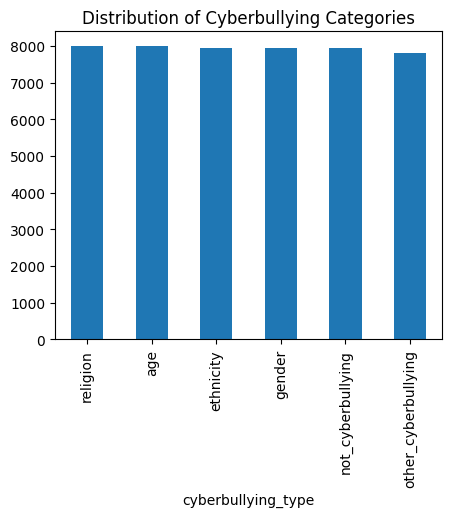

In [23]:
df['cyberbullying_type'].value_counts().plot(kind='bar',
                                              title='Distribution of Cyberbullying Categories',
                                              figsize=(5,4)
                                              )
# The result turns out to be good, the data is balanced 

### Word Cloud for uncleaned data

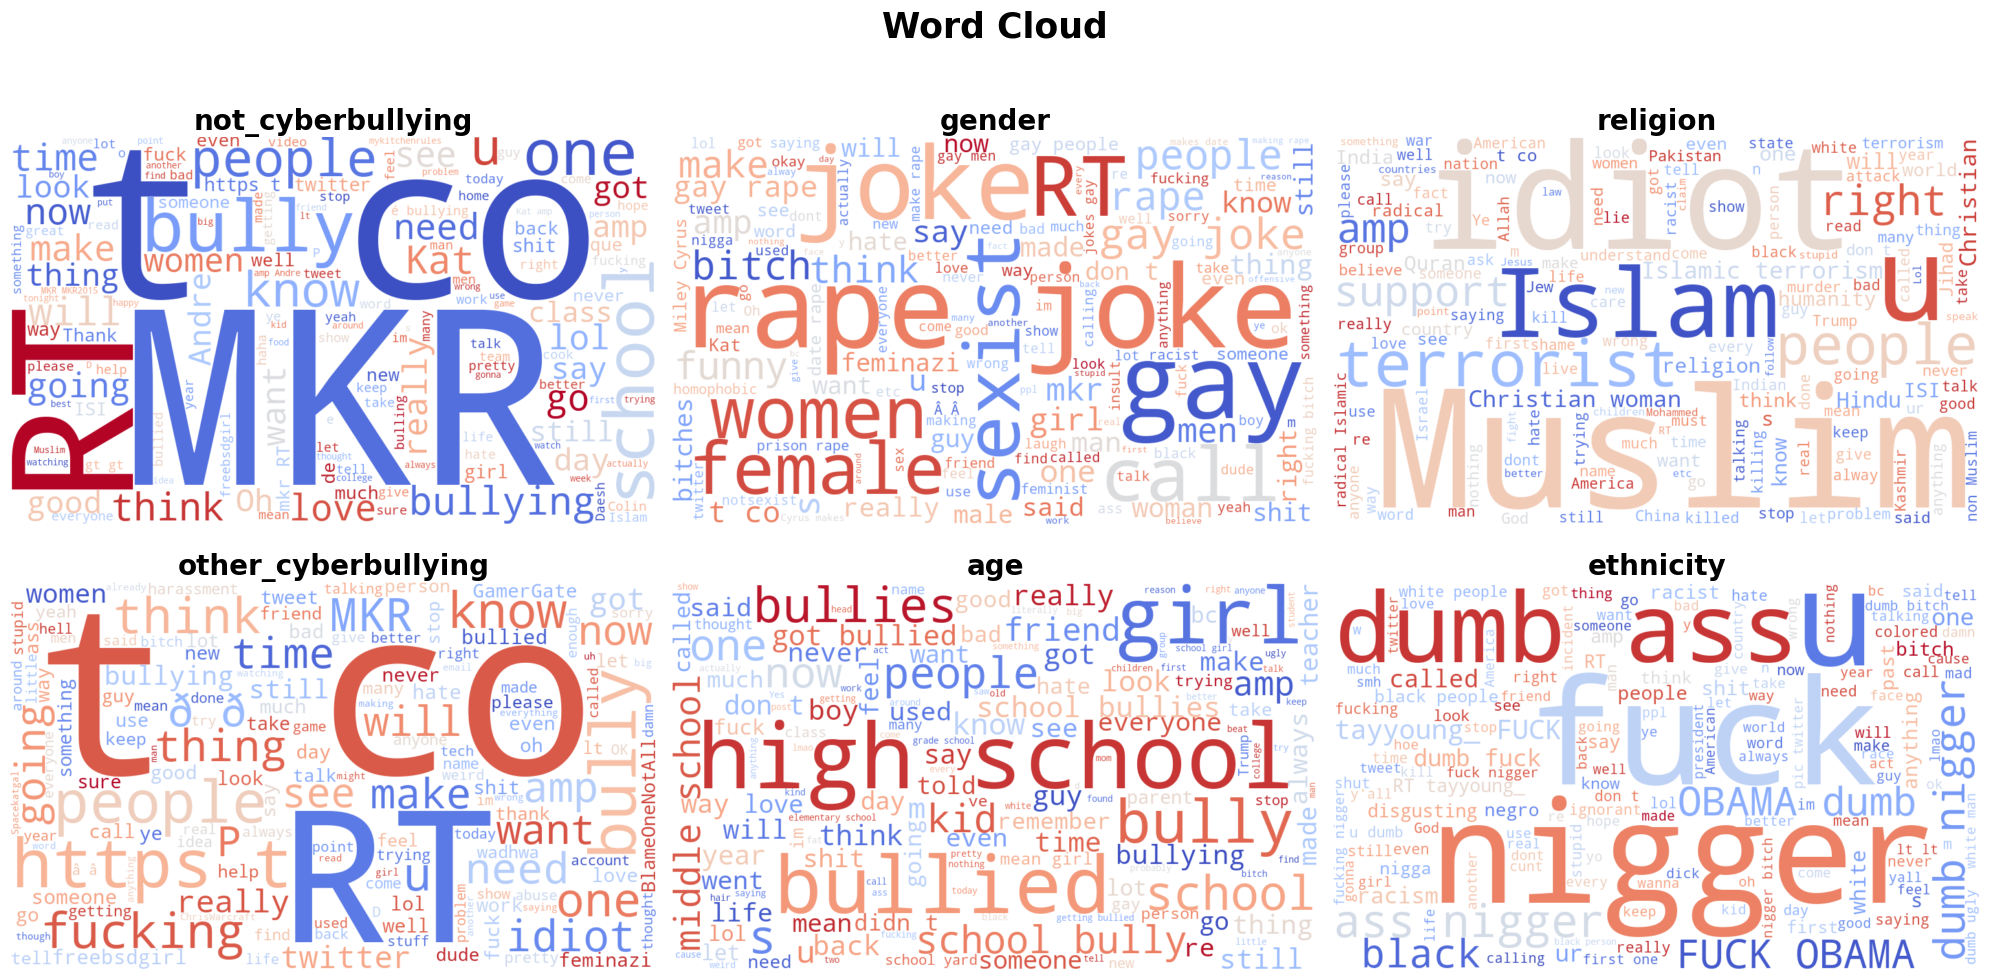

In [24]:

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

unique_labels = df['cyberbullying_type'].unique()
plt.figure(figsize=(20, 10))

for i, label in enumerate(unique_labels, 1):
    # Combine all tweets of this class
    text = " ".join(df[df['cyberbullying_type'] == label]['tweet_text'].astype(str))
    
    # Generate word cloud
    wc = WordCloud(
        width=1000, height=600,
        background_color='white',
        colormap='coolwarm',
        max_words=150,
        contour_color='black',
        contour_width=2
    ).generate(text)
    
    # Plot
    plt.subplot(2, (len(unique_labels)+1)//2, i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{label}", fontsize=20, fontweight='bold')
    
plt.suptitle("Word Cloud", fontsize=25, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



### Normalize the text 

In [25]:
import re

def clean_text(text):
    text = text.lower()                         # lowercase
    text = re.sub(r"http\S+", "", text)         # remove URLs
    text = re.sub(r"@\w+", "", text)            # remove mentions
    text = re.sub(r"#\w+", "", text)            # remove hashtags
    text = re.sub(r"[^a-z\s]", "", text)        # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()    # remove extra spaces
    return text


### Preprocessing

In [26]:
preprocessed_df = df.copy()
#check the na and drop duplicate input
preprocessed_df = preprocessed_df.dropna(subset=['tweet_text', 'cyberbullying_type'])
preprocessed_df = preprocessed_df.drop_duplicates(subset = ['tweet_text']).reset_index(drop=True)
# we drop the other_cyberbullying
preprocessed_df = preprocessed_df[preprocessed_df['cyberbullying_type'] != 'other_cyberbullying'].reset_index(drop=True)

print(" After removing nulls, duplicates, and unwanted class:", preprocessed_df.shape)

# Apply the cleaned text to our newly created Preprocess dataframe 
preprocessed_df = preprocessed_df[preprocessed_df['tweet_text'].astype(str).str.strip() != ""]
preprocessed_df['cleaned_text'] = preprocessed_df['tweet_text'].apply(clean_text)
preprocessed_df = preprocessed_df[preprocessed_df['cleaned_text'].astype(str).str.strip() != ""].reset_index(drop=True)
preprocessed_df = preprocessed_df[preprocessed_df['cleaned_text'].str.len()>0] # Check missing value after cleaning 

# Save the preprocess dataframe 
# preprocessed_df.to_csv("cyberbullying_preprocessed_df.csv", index=False)


print(" Text cleaning process complete!")
print(f"Remaining samples: {len(preprocessed_df)}")
# print(" Preprocessed data saved to: cyberbullying_preprocessed_df.csv")
print("\n Preview of Cleaned Data:")
print(preprocessed_df[['tweet_text', 'cyberbullying_type', 'cleaned_text']].head(10))

 After removing nulls, duplicates, and unwanted class: (39774, 2)
 Text cleaning process complete!
Remaining samples: 39601

 Preview of Cleaned Data:
                                          tweet_text cyberbullying_type  \
0  In other words #katandandre, your food was cra...  not_cyberbullying   
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying   
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying   
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying   
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying   
5  @Raja5aab @Quickieleaks Yes, the test of god i...  not_cyberbullying   
6  Itu sekolah ya bukan tempat bully! Ga jauh kay...  not_cyberbullying   
7  Karma. I hope it bites Kat on the butt. She is...  not_cyberbullying   
8       @stockputout everything but mostly my priest  not_cyberbullying   
9  Rebecca Black Drops Out of School Due to Bully...  not_cyberbullying   

                       

<Axes: title={'center': 'Distribution of Cyberbullying Categories'}, xlabel='cyberbullying_type'>

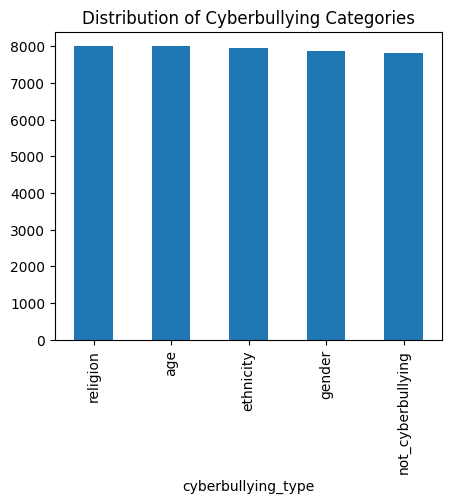

In [27]:
preprocessed_df['cyberbullying_type'].value_counts().plot(kind='bar',
                                              title='Distribution of Cyberbullying Categories',
                                              figsize=(5,4)
                                              )

In [28]:
X = preprocessed_df['cleaned_text'].values
y = preprocessed_df['cyberbullying_type'].values

preprocessed_df.shape
preprocessed_df['cyberbullying_type'].value_counts()

cyberbullying_type
religion             7995
age                  7992
ethnicity            7946
gender               7861
not_cyberbullying    7807
Name: count, dtype: int64

### Word Cloud afte the preprocessing 

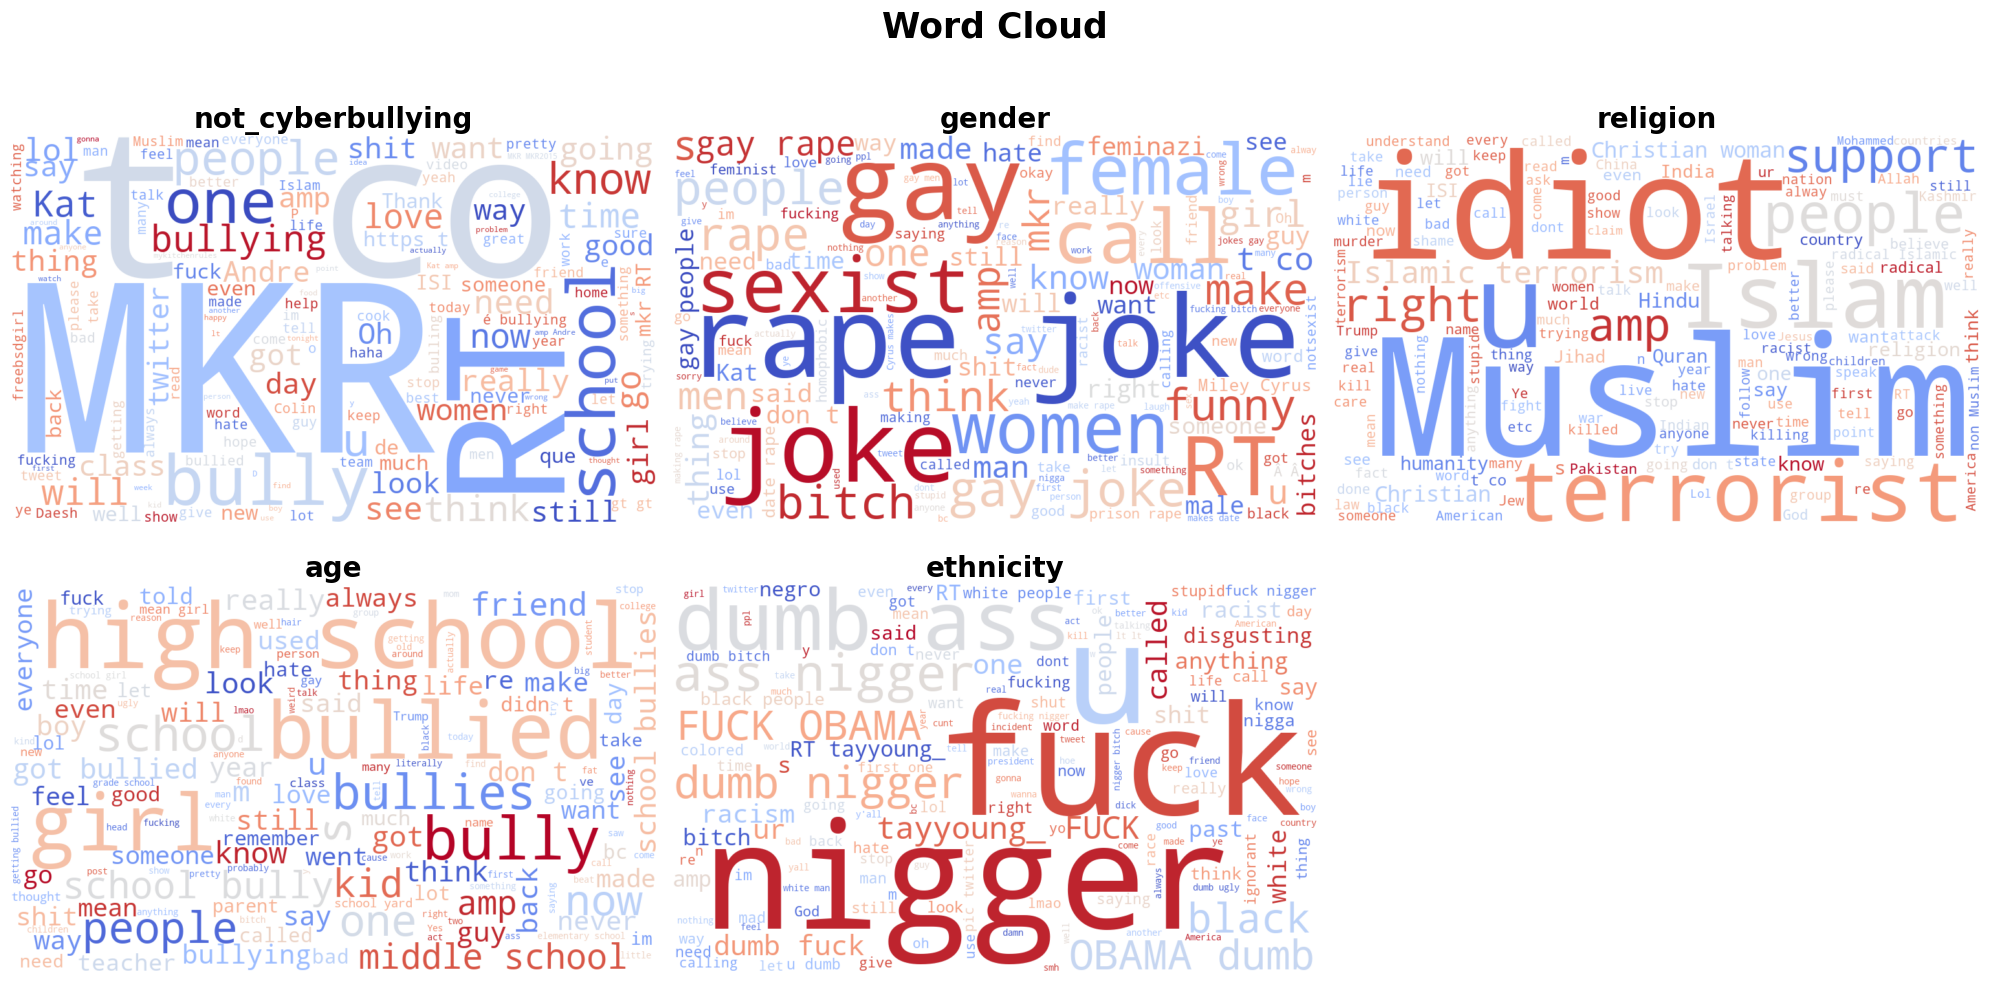

In [29]:

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

unique_labels = preprocessed_df['cyberbullying_type'].unique()
plt.figure(figsize=(20, 10))

for i, label in enumerate(unique_labels, 1):
    # Combine all tweets of this class
    text = " ".join(preprocessed_df[preprocessed_df['cyberbullying_type'] == label]['tweet_text'].astype(str))
    
    # Generate word cloud
    wc = WordCloud(
        width=1000, height=600,
        background_color='white',
        colormap='coolwarm',
        max_words=150,
        contour_color='black',
        contour_width=2
    ).generate(text)
    
    # Plot
    plt.subplot(2, (len(unique_labels)+1)//2, i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{label}", fontsize=20, fontweight='bold')
    
plt.suptitle("Word Cloud", fontsize=25, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


      Dataset Size Comparison
Before Preprocessing : 47,656 rows
After Preprocessing  : 39,601 rows
Rows Removed         : 8,055 rows


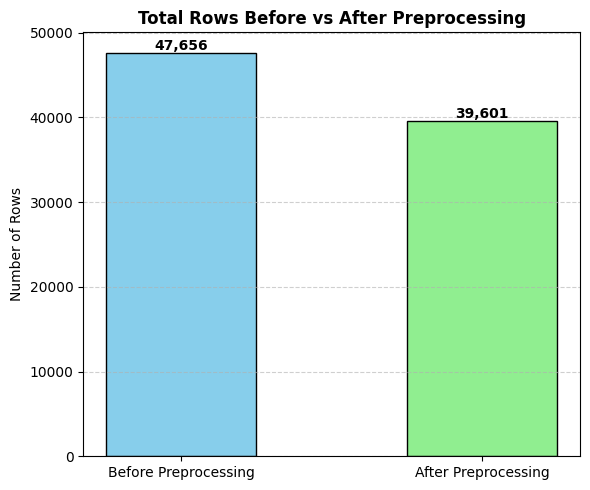

In [30]:
# Count total rows before and after
before_count = len(df)
after_count = len(preprocessed_df)

print("      Dataset Size Comparison")
print("==================================")
print(f"Before Preprocessing : {before_count:,} rows")
print(f"After Preprocessing  : {after_count:,} rows")
print(f"Rows Removed         : {before_count - after_count:,} rows")


plt.figure(figsize=(6, 5))
plt.bar(['Before Preprocessing', 'After Preprocessing'],
        [before_count, after_count],
        color=['skyblue', 'lightgreen'],
        width=0.5,
        edgecolor='black')

# Add value labels
for i, v in enumerate([before_count, after_count]):
    plt.text(i, v + 300, f"{v:,}", ha='center', fontweight='bold')


plt.title("Total Rows Before vs After Preprocessing", fontweight='bold')
plt.ylabel("Number of Rows")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### Train Test Split

#### To turn sparse matrix to str array, 
##### we use:
##### -X_train_dense = X_train.toarray() #use a lot of memory 
   #####  X_train_str = X_train_dense.astype(str)

In [31]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.1765, random_state=42, stratify=y_temp)
print('\nShape:')
print(f'X_train shape: {len(X_train)} samples')
print(f'X_test shape: {len(X_test)} samples')
print(f'X_val shape: {len(X_val)} samples')
print(f'X_temp shape: {len(X_temp)} samples')
### 70/15/15 split 


Shape:
X_train shape: 27719 samples
X_test shape: 5941 samples
X_val shape: 5941 samples
X_temp shape: 33660 samples


### Feature Extraction -- TF-IDF

In [32]:


vectorizer = TfidfVectorizer(ngram_range=(1,2),
                            max_features=5000,
                            stop_words='english'
                            )
tfidf_X_train = vectorizer.fit_transform(X_train) # turn array into sparse matrix 
tfidf_X_val = vectorizer.transform(X_val)
tfidf_X_test = vectorizer.transform(X_test)
feature_y = preprocessed_df['cyberbullying_type']
vocab = vectorizer.vocabulary_

tfidf_X_train.shape
tfidf_X_val.shape
tfidf_X_test.shape

(5941, 5000)

### Try using the Gradient Boosting

#### One hot Encoder 

In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
labels = [['age'], ['ethnicity'], ['gender'], ['not_cyberbullying'], ['religion']]

encoder = OneHotEncoder(sparse_output=False)
binary = encoder.fit_transform(labels)

print(binary)

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.fit_transform(y_val)
y_test_encoded = le.fit_transform(y_test)


y_train_encoded.dtype

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


dtype('int64')

In [34]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import MultinomialNB
import xgboost

xgb_clf = xgboost.XGBClassifier(objective="multi:softprob",
                                num_class=5,
                                eval_metric="mlogloss"
                                )

voting_clf = VotingClassifier([('lr', LogisticRegression(max_iter=1000)),
                                 ('nb', MultinomialNB()),
                                ('xgb', xgb_clf)], 
                                voting='soft')

#print(type(voting_clf.estimators))
#print(voting_clf.estimators)

voting_clf.fit(tfidf_X_train, y_train_encoded)
# We make a prediction on validation set 

pred_y_val = voting_clf.predict(tfidf_X_val)
accuracy_val = accuracy_score(y_val_encoded, pred_y_val)


print('\nValidation set Performance with TF-IDF:')
print(f'Accuracy: {accuracy_val:.4f}')
print('\nClassification Report:')
print(classification_report(y_val_encoded, pred_y_val))


pred_y_test = voting_clf.predict(tfidf_X_test)
accuracy_test = accuracy_score(y_test_encoded, pred_y_test)

print('\nTest set Performance with TF-IDF:')
print(f'Accuracy: {accuracy_test:.4f}')
print('\nClassification Report:')
print(classification_report(y_test_encoded, pred_y_test))


Validation set Performance with TF-IDF:
Accuracy: 0.9239

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1199
           1       0.99      0.98      0.99      1192
           2       0.95      0.83      0.89      1180
           3       0.78      0.88      0.83      1171
           4       0.95      0.95      0.95      1199

    accuracy                           0.92      5941
   macro avg       0.93      0.92      0.92      5941
weighted avg       0.93      0.92      0.92      5941


Test set Performance with TF-IDF:
Accuracy: 0.9281

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1199
           1       0.97      0.99      0.98      1192
           2       0.95      0.84      0.89      1179
           3       0.80      0.88      0.84      1171
           4       0.96      0.94      0.95      1200

    accuracy               

In [35]:
# from sklearn.model_selection import cross_val_score
# # Cross validation score help us by assessing the model performance in real world practice 
# scores = cross_val_score(voting_clf, X_train, y_train_encoded,
#                          cv=5, scoring="f1_macro")

# print("Macro F1 CV:", scores.mean())

### Logistic Regression

In [ ]:

classi_tfidf = LogisticRegression(max_iter=1000,
                                  C=1,                      # we can tune this 
                                  class_weight='balanced',  # it is helpful when sligh imbalance happen
                                  random_state=42)

classi_tfidf.fit(tfidf_X_train, y_train)
# We make a prediction on validation set 

pred_y_val = classi_tfidf.predict(tfidf_X_val)
accuracy_val = accuracy_score(y_val, pred_y_val)


print('\nValidation set Performance with TF-IDF:')
print(f'Accuracy: {accuracy_val:.4f}')
print('\nClassification Report:')
print(classification_report(y_val, pred_y_val))


pred_y_test = classi_tfidf.predict(tfidf_X_test)
accuracy_test = accuracy_score(y_test, pred_y_test)

print('\nTest set Performance with TF-IDF:')
print(f'Accuracy: {accuracy_test:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, pred_y_test))

AttributeError: 'LogisticRegression' object has no attribute 'fit_transform'

In [ ]:
best_acc = 0
best_C = None
best_model = None

for C in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0]:
    clf = LogisticRegression(max_iter=1000, C=C, random_state=42)
    clf.fit(tfidf_X_train, y_train)
    pred_val = clf.predict(tfidf_X_val)
    acc = accuracy_score(y_val, pred_y_val)
    print(f"C = {C:4.1f} → Val accuracy: {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        best_C = C
        best_model = clf

print(f"\nBest C = {best_C} (val acc = {best_acc:.4f})")

# Now use best_model on test set
pred_y_test = best_model.predict(tfidf_X_test)
print("\nTest accuracy with best model:", accuracy_score(y_test, pred_y_test))

C =  0.1 → Val accuracy: 0.9150
C =  0.5 → Val accuracy: 0.9150
C =  1.0 → Val accuracy: 0.9150
C =  2.0 → Val accuracy: 0.9150
C =  5.0 → Val accuracy: 0.9150
C = 10.0 → Val accuracy: 0.9150

Best C = 0.1 (val acc = 0.9150)

Test accuracy with best model: 0.9055714526174045


##### The gradient boost model perform slightly better than the logistic regression

### Confusion Matrix

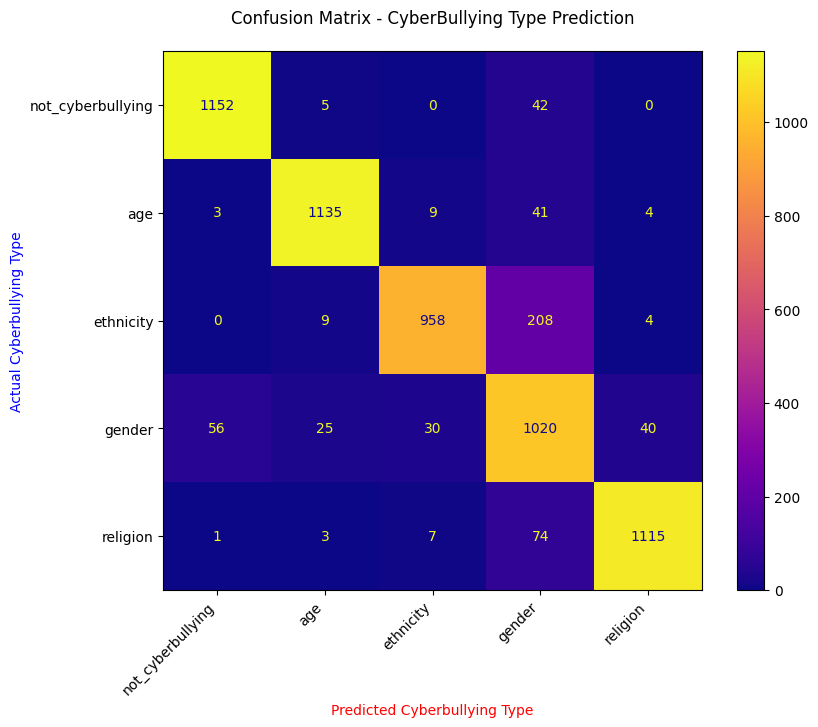

In [ ]:
class_names = ['not_cyberbullying', 
               'age',
               'ethnicity',
               'gender',
               'religion']

cm = confusion_matrix(y_test, pred_y_test)

dist = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(9,7))
dist.plot(ax=ax, 
          cmap='plasma',
          values_format='d',
          colorbar=True)
plt.title("Confusion Matrix - CyberBullying Type Prediction",
            pad=20)
plt.xlabel('Predicted Cyberbullying Type', color='Red')
plt.ylabel('Actual Cyberbullying Type', color='blue') 
plt.xticks(rotation=45, ha='right') #rotate the long label 
plt.yticks()
plt.show()

### ROC_AUC 
##### To measure and plot the accuracy 

In [ ]:

pred_y_prob = classi_tfidf.predict_proba(tfidf_X_test)


macro_auc = roc_auc_score(y_test, pred_y_prob, multi_class='ovr', average='macro')
weighted_auc = roc_auc_score(y_test, pred_y_prob, multi_class='ovr', average='weighted')
#Macro is useful when we want under-represented classes to have equal importance to common ones.
print(f"Macro-averaged ROC-AUC (OvR):    {macro_auc:.4f}")
print(f"Weighted-averaged ROC-AUC (OvR): {weighted_auc:.4f}")


per_class_auc = roc_auc_score(y_test, pred_y_prob, multi_class='ovr', average=None)
for i, name in enumerate(class_names):
    print(f'{name:18} AUC: {per_class_auc[i]:.4f}')

Macro-averaged ROC-AUC (OvR):    0.9878
Weighted-averaged ROC-AUC (OvR): 0.9879
not_cyberbullying  AUC: 0.9976
age                AUC: 0.9983
ethnicity          AUC: 0.9846
gender             AUC: 0.9644
religion           AUC: 0.9940


/Users/jeldy/Documents/ML_AI_and_Data_Science/Project/cyberbullyclassification/mynewvenv/lib/python3.14/site-packages/sklearn/metrics/_ranking.py:1303: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/jeldy/Documents/ML_AI_and_Data_Science/Project/cyberbullyclassification/mynewvenv/lib/python3.14/site-packages/sklearn/metrics/_ranking.py:1303: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/jeldy/Documents/ML_AI_and_Data_Science/Project/cyberbullyclassification/mynewvenv/lib/python3.14/site-packages/sklearn/metrics/_ranking.py:1303: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/jeldy/Documents/ML_AI_and_Data_Science/Project/cyberbullyclassification/mynewvenv/lib/python3.14/site-packages/sklearn/metrics/_ranking.py:1303: UndefinedMetricWarning: No positive samples in y_t

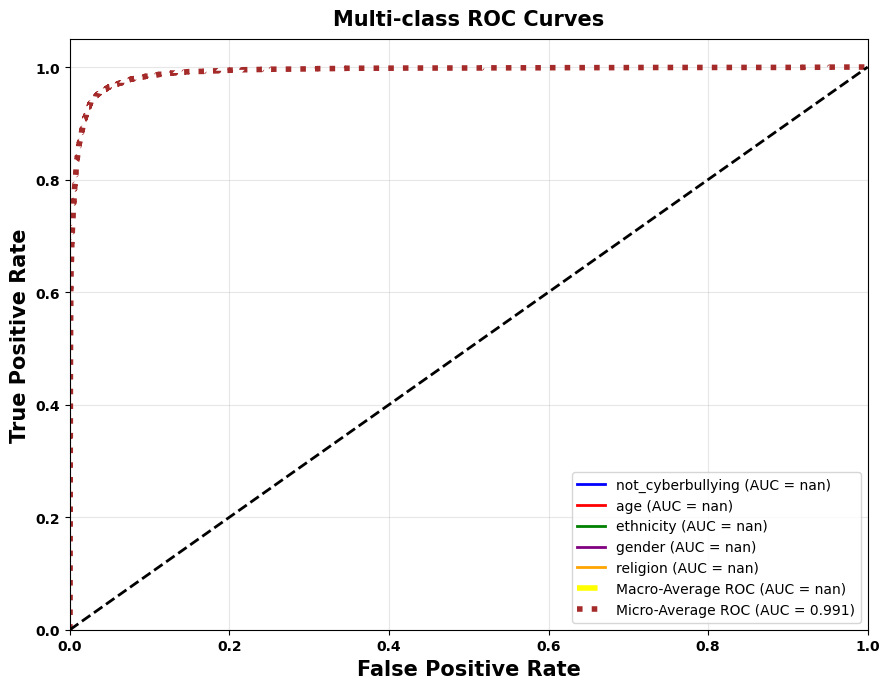

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_test_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = len(class_names)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, pred_y_prob[:, i])
    roc_auc[i] = auc( fpr[i], tpr[i])


plt.figure(figsize=(9,7))
colors = ['blue', 'red', 'green', 'purple', 'orange']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), pred_y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average (mean of all class ROC curves)
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


plt.plot(fpr['macro'], tpr['macro'], 
         color='yellow', 
         linestyle='--',
         linewidth=4,
         label=f'Macro-Average ROC (AUC = {roc_auc['macro']:.3f})'
         )
plt.plot(fpr['micro'], tpr['micro'], 
         color='brown', 
         linestyle=':',
         linewidth=4,
         label=f'Micro-Average ROC (AUC = {roc_auc['micro']:.3f})'
         )

plt.plot([0, 1], [0, 1], 'k--', lw=2) #Reference line 

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.title('Multi-class ROC Curves', fontsize=15, fontweight='bold', pad=10)
plt.xlabel('False Positive Rate', fontsize=15, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=15, fontweight='bold')

plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.legend(loc="lower right", frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Word Embedding 

In [ ]:

# from transformers import DistilBertTokenizer, AutoTokenizer
# import torch 

# tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
# train_encodings = tokenizer(X_train,
#                      truncation=True,
#                      padding=True,
#                      max_length=128)
# val_encodings = tokenizer(X_val,
#                      truncation=True,
#                      padding=True,
#                      max_length=128)



In [ ]:

# class Cyberbullying(torch.utils.data.Dataset):
#     def __init__(self, encodings, labels):
#         self.encodings = encodings
#         self.labels = labels

#     def __getitem__(self, idx):
#         item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
#         item["labels"] = torch.tensor(self.labels[idx])
#         return item

#     def __len__(self):
#         return len(self.labels)

# train_dataset = CyberDataset(train_encodings, X_train)
# val_dataset = CyberDataset(val_encodings, X_val)



In [ ]:
# from transformers import DistilBertForSequenceClassification

# model = DistilBertForSequenceClassification.from_pretrained(
#     'distilbert-base-uncased',
#     num_labels=num_labels
# )


### Check if we have GPU or not 

In [ ]:

# print(torch.cuda.is_available())


### Performance Metric 

In [ ]:
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = logits.argmax(axis=1)

#     precision, recall, f1, _ = precision_recall_fscore_support(
#         labels, predictions, average='weighted'
#     )

#     acc = accuracy_score(labels, predictions)

#     return {
#         "accuracy": acc,
#         "f1": f1,
#         "precision": precision,
#         "recall": recall
#     }
